In [14]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pathlib import Path
import random
from numba import njit

sys.path.append(os.path.abspath(os.path.join('../src')))
from varying_drift_diffusion import *
from motion_simulation import *
from accumulators import *

# bayesflow
sys.path.append(os.path.abspath(os.path.join('../../BayesFlow')))
from bayesflow.networks import InvariantNetwork, InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *

from tensorflow.keras.layers import Dense, GRU, LSTM, Conv1D, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential

In [15]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

In [16]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constants

In [17]:
# simulation 
N_SIM = 500
N_OBS = 100

# bayesflow
PARAM_NAMES = ["a", "ndt", "bias", "kappa"]
N_PARAMS = len(PARAM_NAMES)
N_EPOCHS = 50
ITER_PER_EPOCH = 1000
BATCH_SIZE = 32
N_SAMPLES = 200

## Simulator Test

In [18]:
n_obs = 100
a     = 3.0
ndt   = 0.2
bias  = 0.5
kappa = 5
theta = np.array([a, ndt, bias, kappa])

unique_motions = np.array([-0.725, -0.675, -0.625, -0.575, -0.525, 0.525,  0.575,  0.625,  0.675,  0.725], dtype=np.float32)
amplitude = np.repeat(unique_motions, 10)
motion_set, condition = motion_experiment_manual(1, amplitude, 1)

rt, resp = var_dm_simulator(theta, 1, motion_set)


In [19]:
%time
p_, x_ = var_dm_batch_simulator(32, 100)
x_.shape

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


(32, 100, 12)

## Bayes Flow

In [36]:
class CustomSummary(tf.keras.Model):
    
    def __init__(self, meta_inv, n_out=10):
        super(CustomSummary, self).__init__()
        self.inv = InvariantNetwork(meta_inv)
        self.out = Dense(n_out)
        
    def call(self, x):
        return self.out(self.inv(x)) 

In [38]:
sum_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    2,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

# invertable inference network
inf_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'alpha': 1.9,
    'permute': True,
    'use_act_norm': True,
    'n_params': N_PARAMS
}

inference_net = InvertibleNetwork(inf_meta)
summary_net = CustomSummary(sum_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)

In [39]:
# Learning-rate decay
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0005, 1000, 0.99, staircase=True
)

trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=var_dm_batch_simulator,
    learning_rate=learning_rate,
    checkpoint_path='../src/selected_checkpoints/time_var_dm2',
    clip_value=3,
    max_to_keep=5
)

Initializing networks from scratch.


In [52]:
# Learning-rate decay
trainer.optimizer = tf.keras.optimizers.Adam(0.00007)

In [54]:
# # %%time
# # # online training
# losses = trainer.train_online(5, ITER_PER_EPOCH, BATCH_SIZE, n_obs=N_OBS)

## Parameter Recovery

In [48]:
# Simulate and amortized inference
p_, x_ = var_dm_batch_simulator(n_sim=N_SIM,n_obs=N_OBS)

In [55]:
samples = amortizer.sample(x_, n_samples=N_SAMPLES)
param_means = samples.mean(axis=1)

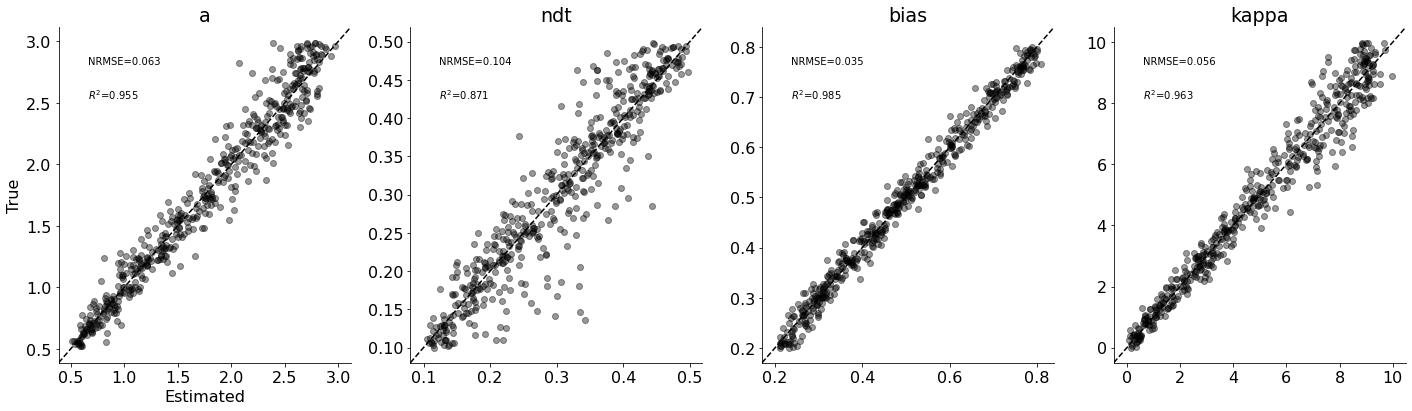

In [56]:
# Recovery plot
f = true_vs_estimated(theta_true=p_, theta_est=param_means,
                  param_names=PARAM_NAMES, dpi=300, figsize=(20,6),font_size=16)

In [ ]:
sns.pairplot(pd.DataFrame(samples[0], columns=PARAM_NAMES))

## Simulation Based Calibration

In [44]:
# Simulate
n_sbc = 5000
n_post_samples_sbc = 250
params, sim_data = var_dm_batch_simulator(n_sbc, N_OBS)

In [57]:
# Amortized inference
param_samples = np.concatenate([amortizer.sample(x, n_post_samples_sbc)
                                for x in tf.split(sim_data, 10, axis=0)], axis=0)

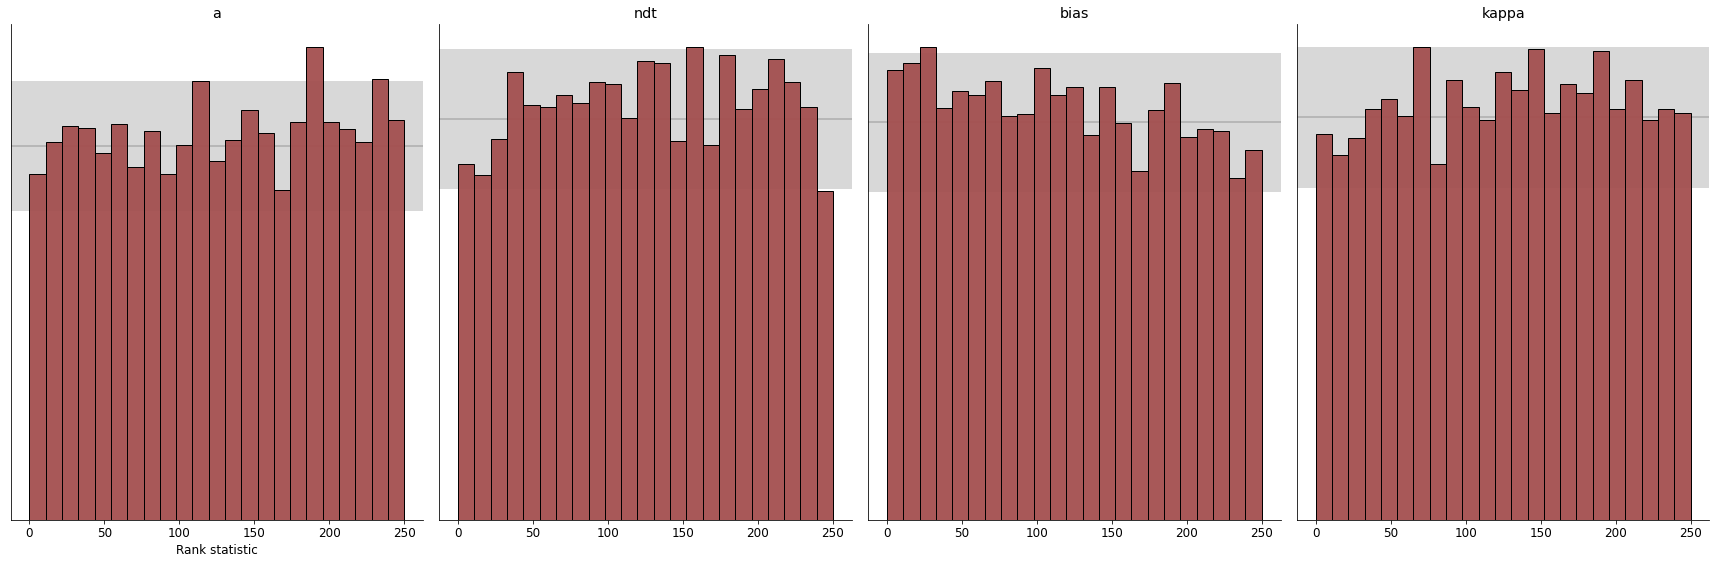

In [64]:
# Rank-plot
f = plot_sbc(param_samples, params, param_names=PARAM_NAMES, figsize=(24, 8), bins=23)

## Bayesian Eye Chart

In [65]:
# Simulation
true_params, sim_data = var_dm_batch_simulator(N_SIM, N_OBS)

# Amortized inference
param_samples = np.concatenate([amortizer.sample(x, N_SAMPLES)
                                for x in tf.split(sim_data, 10, axis=0)], axis=0)

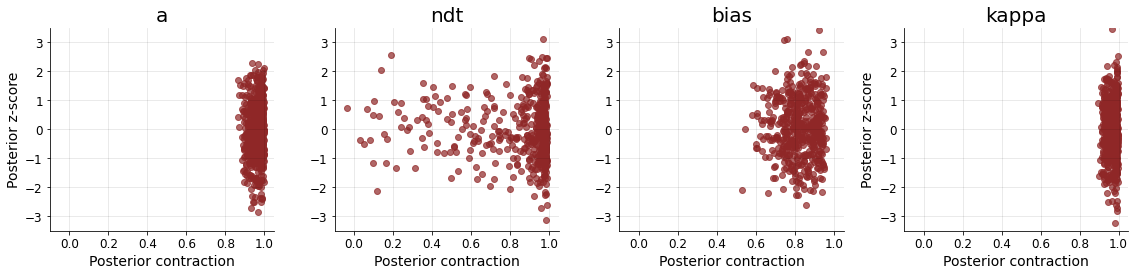

In [67]:
### Posterior z-score
# Compute posterior means and stds
post_means = param_samples.mean(1)
post_stds = param_samples.std(1)
post_vars = param_samples.var(1)

# Compute posterior z score
post_z_score = (post_means - true_params) / post_stds

### Posterior contraction, i.e., 1 - post_var / prior_var
prior_a = (0.5, 0.1, 0.0) # lower bound of uniform prior
prior_b = (3.0, 0.5, 10.0) # upper bound of uniform prior

# Compute prior vars analytically
prior_vars = np.array([(b-a)**2/12 for a,b in zip(prior_a, prior_b)])
prior_vars = np.concatenate((prior_vars[0:2], np.array([0.0025]), prior_vars[2:]))
post_cont = 1 - post_vars / prior_vars

# Plotting time
f, axarr = plt.subplots(1, 4, figsize=(16, 4))
for i, (p, ax) in enumerate(zip(PARAM_NAMES, axarr.flat)):


    ax.scatter(post_cont[:, i], post_z_score[:, i], color='#8f2727', alpha=0.7)
    ax.set_title(p, fontsize=20)
    sns.despine(ax=ax)
    ax.set_xlim([-0.1, 1.05])
    ax.set_ylim([-3.5, 3.5])
    ax.grid(color='black', alpha=0.1)
    ax.set_xlabel('Posterior contraction', fontsize=14)
    if i == 0 or i == 3:
        ax.set_ylabel('Posterior z-score', fontsize=14)
f.tight_layout()

In [ ]:
# empirical data preparation
directory = str(Path().absolute())
path = str(Path(directory).parents[1]) + '/evidence-accumulators/data/single_sub_data.csv'
# data = np.loadtxt(open(path, 'rb'), delimiter=",", skiprows=1)
data = pd.read_csv(path)

In [ ]:
idx = np.where((data["condition"] == 1) & (data["instruction"] == 1))
data = data.loc[idx]
data.head()

In [ ]:
amplitude = data["motion"]
frequency = data["motion_duration"][0]
motion_dur = data["motion_duration"][0]

motion_set, condition = motion_experiment_manual(motion_dur, amplitude, frequency)


In [ ]:
directory = str(Path().absolute())
path = str(Path(directory).parents[1]) + '/evidence-accumulators/data/single_sub_data.csv'
# data = np.loadtxt(open(path, 'rb'), delimiter=",", skiprows=1)
data = pd.read_csv(path)
idx = np.where((data["condition"] == 1) & (data["instruction"] == 1))
data = data.loc[idx]
amplitude = data["motion"]
frequency = data["motion_duration"][0]
motion_dur = data["motion_duration"][0]

motion_set, condition = motion_experiment_manual(motion_dur, amplitude, frequency)

In [ ]:
unique_motions = np.array([-0.725, -0.675, -0.625, -0.575, -0.525,
                           0.525,  0.575,  0.625,  0.675,  0.725], dtype=np.float32)

In [ ]:
 x_ = np.repeat(unique_motions, 10)

In [ ]:
motion_set, condition = motion_experiment_manual(motion_dur, x_, frequency)

In [ ]:
motion_set

In [ ]:
motion_set[np.random.choice(motion_set.shape[0], motion_set.shape[0], replace=False)]

In [ ]:
# get exact motion profile used in the data
directory = str(Path().absolute())
path = str(Path(directory).parents[1]) + '/evidence-accumulators/data/single_sub_data.csv'
# data = np.loadtxt(open(path, 'rb'), delimiter=",", skiprows=1)
data = pd.read_csv(path)
idx = np.where((data["condition"] == 1) & (data["instruction"] == 1))
data = data.loc[idx]
amplitude = data["motion"]
frequency = data["motion_duration"][0]
motion_dur = data["motion_duration"][0]

motion_set, condition = motion_experiment_manual(motion_dur, amplitude, frequency)

In [ ]:
unique_motions = np.array([-0.725, -0.675, -0.625, -0.575, -0.525,
                           0.525,  0.575,  0.625,  0.675,  0.725], dtype=np.float32)
amplitude = np.repeat(unique_motions, 10)
motion_set, condition = motion_experiment_manual(1, amplitude, 1)

In [ ]:
rng = np.random.default_rng(2021)
rng.uniform(0.5, 5, size=5)
rng.uniform(0.5, 5, size=5)

In [ ]:
unique_motions = np.array([-0.725, -0.675, -0.625, -0.575, -0.525,
                           0.525,  0.575,  0.625,  0.675,  0.725], dtype=np.float32)
amplitude = np.repeat(unique_motions, 10)
motion_set, condition = motion_experiment_manual(1, amplitude, 1)

In [ ]:
shuffler = np.random.permutation(len(motion_set))

In [ ]:
motion_set[shuffler, :]
condition[shuffler, :]

In [ ]:
n_unique_motions = 5
motion_dur = 1
motion_set, condition = motion_experiment(n_obs, n_unique_motions, motion_dur)
motion_set.shape

In [ ]:
unique_motions = np.array([-0.725, -0.675, -0.625, -0.575, -0.525,
                       0.525,  0.575,  0.625,  0.675,  0.725], dtype=np.float32)
amplitude = np.repeat(unique_motions, 10)
motion_set, condition = motion_experiment_manual(1, amplitude, 1)
motion_set.shape

In [ ]:
n_unique_motions = 5
motion_dur = 1
motion_set, condition = motion_experiment(n_obs, n_unique_motions, motion_dur)
motion_set.shape
condition

In [ ]:
unique_motions = np.array([-0.725, -0.675, -0.625, -0.575, -0.525,
                       0.525,  0.575,  0.625,  0.675,  0.725], dtype=np.float32)
amplitude = np.repeat(unique_motions, 10)
motion_set, condition = motion_experiment_manual(1, amplitude, 1)
motion_set.shape
condition

In [ ]:
shuffler = np.random.permutation(len(motion_set))
motion_set = motion_set[shuffler, :]
condition = condition[shuffler, :]

In [ ]:
condition

In [ ]:
unique_motions = np.array([-0.725, -0.675, -0.625, -0.575, -0.525, 0.525,  0.575,  0.625,  0.675,  0.725], dtype=np.float32)
amplitude = np.repeat(unique_motions, 10)
motion_set, condition = motion_experiment_manual(1, amplitude, 1)

In [ ]:
condition[0:100, :].shape

In [19]:
unique_motions = np.array([-0.725, -0.675, -0.625, -0.575, -0.525, 0.525,  0.575,  0.625,  0.675,  0.725], dtype=np.float32)
amplitude = np.repeat(unique_motions, 10)
motion_set, condition = motion_experiment_manual(1, amplitude, 1)

In [21]:
@njit
def test_fun(motion_set, condition):
    shuffler = np.random.permutation(len(motion_set))
    motion_set = motion_set[shuffler, :]
    condition = condition[shuffler, :]
    
    return motion_set, condition

In [22]:
test_fun(motion_set, condition)

(array([[-0.        , -0.00001799, -0.00007195, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.00001305,  0.00005221, ...,  0.        ,
          0.        ,  0.        ],
        [-0.        , -0.00001305, -0.00005221, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.        , -0.00001305, -0.00005221, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.00002075,  0.000083  , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.00001088,  0.00004352, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0.